In [1]:
from astropy.io import ascii
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from photutils import Background2D
from astropy.table import Column
from photutils  import detect_sources
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import source_properties

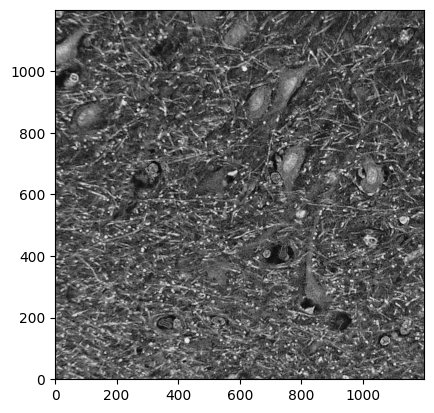

In [2]:
#load the image

im=fits.open('CORTEX40.fits')[0]
plt.imshow(im.data,cmap='Greys_r',origin='lower')

In [53]:
#segm detection

#bkg=Background2D(im.data,(128,128),filter_size=(3,3))
#th=bkg.background+(3.0*bkg.background_rms)
#th=np.mean(im.data)*10
#segm=detect_sources(im.data,th,npixels=10)
#plt.imshow(segm.data,cmap='Greys_r',origin='lower')

In [54]:
#sigma=3.0*gaussian_fwhm_to_sigma
#kernel=Gaussian2DKernel(sigma,x_size=3,y_size=3)
#kernel.normalize()
#segm=detect_sources(im.data,th,npixels=10)
#fits.writeto('segm_CORTEX40.fits',segm.data,im.header,overwrite=True)
#cat=source_properties(im.data,segm)
#tbl=cat.to_table()
#tbl.write('gaussian.csv' , format='ascii', overwrite='True')

## Finding peaks

In [82]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image
from photutils.detection import find_peaks

mean, median, std = sigma_clipped_stats(im.data, sigma=3.0)
threshold = median + (5. * std)
tbl = find_peaks(im.data, threshold, box_size=10)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#print(tbl[:10])  # print only the first 10 peaks
tbl.write('peaks.csv' , format='ascii', overwrite=True)

### Source detection

C:\Users\rosha\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  


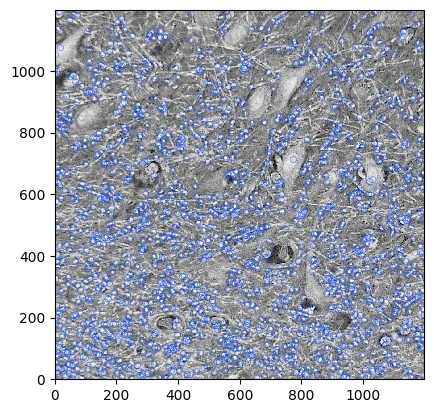

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=10.)
norm = simple_norm(im.data, 'sqrt', percent=99.9)
plt.imshow(im.data, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
apertures.plot(color='#0547f9', lw=0.3)
plt.xlim(0, im.data.shape[1]-1)
plt.ylim(0, im.data.shape[0]-1)

plt.savefig('Peak finding.pdf',dpi=1000,overwrite=True)

finding the network with probability pk(r,r0) by distance

In [88]:
from astropy.io import ascii
from astropy.io import fits
import numpy as np
from random import random
import networkx as nx
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

r0=40

def pk(r,r0):
    return np.exp(-r/r0)

def sep(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)
data=ascii.read('peaks.csv')
N=len(data)
A=np.zeros([N,N])

for i in range(N):
    for j in range(N):
        r=sep(data['x_peak'][i],data['y_peak'][i],data['x_peak'][j],data['y_peak'][j])
        A[i][j]=pk(r,r0)
        if i!=j:
            if pk(r,r0)>random():
                A[i][j]=1
            else:
                A[i][j]=0
        else:
            A[i][j]=0

Text(0.5, 1.0, 'Probability Dist pk')

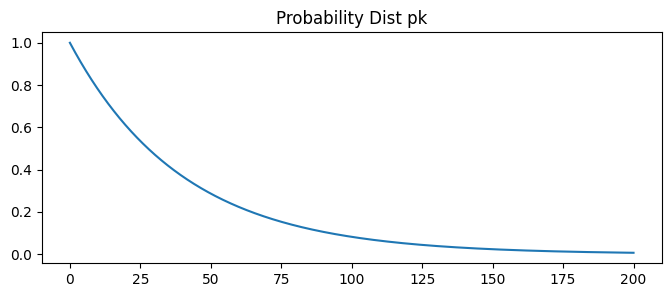

In [164]:
x=np.arange(0,200,0.001)
plt.figure(figsize=(8,3))
plt.plot(x,pk(x,40))
plt.title('Probability Dist pk')

* Plot the network on the image and save adjacency matrix

C:\Users\rosha\anaconda3\envs\python37\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  if sys.path[0] == "":


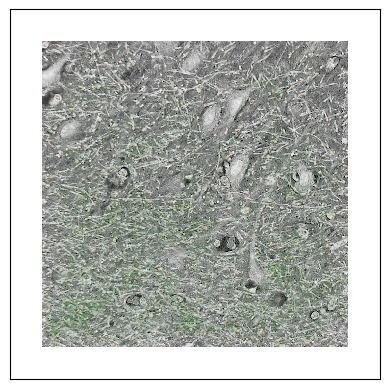

In [89]:

pos={}
for i in range(len(data)):
    pos[i]=data['x_peak'][i],data['y_peak'][i]
    
G = nx.from_numpy_array(A)
im=fits.open('CORTEX40.fits')[0]
norm = simple_norm(im.data, 'sqrt', percent=99.9)
plt.imshow(im.data[, cmap='Greys_r', origin='lower', norm=norm,interpolation='nearest')
nx.draw_networkx_nodes(G = G, pos = pos,node_color = 'r', alpha = 0.2, node_size = 0.1)
nx.draw_networkx_edges(G = G, pos = pos, edge_color='g',width=0.01, arrows = False)

plt.savefig('Graph(r=40).pdf',dpi=1000,overwrite=True)

# save the matrix

hdu=fits.PrimaryHDU(A)
hdul = fits.HDUList([hdu])
hdul.writeto('Adj_Matrix_Peaks_r=40.fits',overwrite=True)

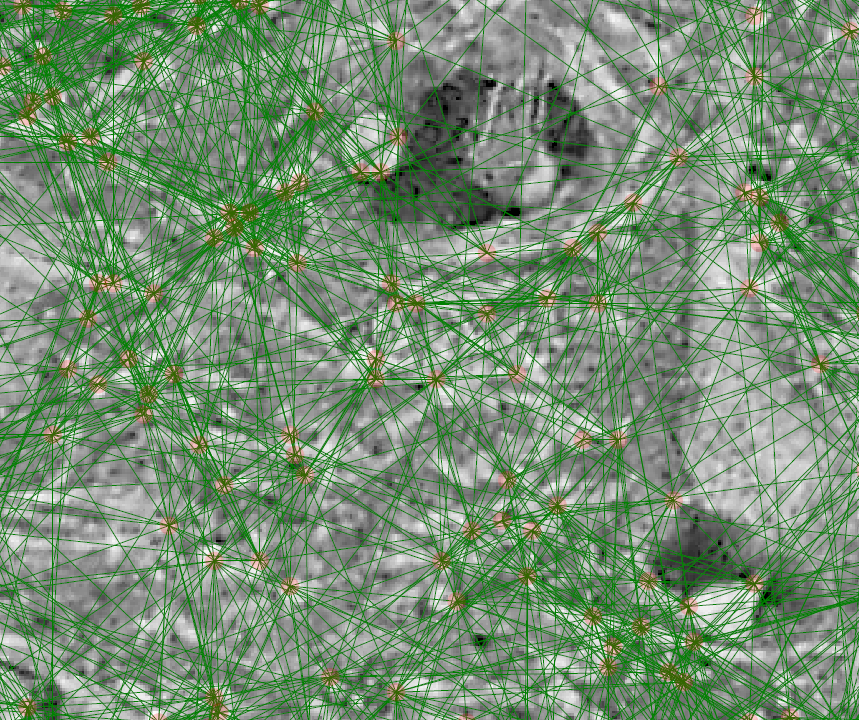

In [128]:
from IPython.display import Image

fig = Image(filename=('green.png'),width=400)
fig